In [ ]:
!pip install transformers==3

     |████████████████████████████████| 757kB 3.9MB/s 
     |████████████████████████████████| 1.2MB 23.7MB/s 
     |████████████████████████████████| 901kB 33.3MB/s 
     |████████████████████████████████| 3.0MB 41.4MB/s 


In [ ]:
!pip install opacus

     |████████████████████████████████| 102kB 2.8MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# Importing libraries
import pandas as pd
import torch
import torch.nn as nn
import transformers
from torch.utils.data import Dataset, DataLoader
# Optimizer from hugging face transformers
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import opacus
from opacus import PrivacyEngine 
import copy
import os
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
# Setting up GPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/dep1_cleaned.csv')
df.head()

,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty ; laughs Kung Fu Pan...,0
1,1,I get to spend New Year's home again alone and...,1
2,2,"Depressed and lonely /: Stuck in a deep, never...",1
3,3,If this is your response to someone saying the...,0
4,4,Apparently you get a free pass just by mention...,0


##Partitioning

###IID

In [ ]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

###Non-IID

In [ ]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.get_labels()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict

# MAIN

## MODELS

In [ ]:
# Importing BERT-base pretrained model
bert = AutoModel.from_pretrained('albert-base-v2')
# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

In [ ]:
# Model Architecture

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # Dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # Relu activation function
      self.relu =  nn.ReLU()

      # Dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # Dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      # Softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    # Define the forward pass
    def forward(self, sent_id, mask):

      # Pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # Output layer
      x = self.fc2(x)
      
      # Apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# Pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# Push the model to GPU
model = model.to(device)

In [ ]:
trainable_layers = [model.fc1, model.fc2]
total_params = 0
trainable_params = 0

for p in model.parameters():
        p.requires_grad = False
        total_params += p.numel()

for layer in trainable_layers:
    for p in layer.parameters():
        p.requires_grad = True
        trainable_params += p.numel()

print(f"Total parameters count: {total_params}") # ~125M
print(f"Trainable parameters count: {trainable_params}") # ~0.5M

Total parameters count: 12078338
Trainable parameters count: 394754


In [ ]:
#Initialization
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 2
#EPOCHS = 10
LEARNING_RATE = 1e-05
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
#The class is defined to accept the Dataframe as input and generate tokenized output that is used by the DistilBERT model for training.
#The tokenizer uses the encode_plus method to perform tokenization and generate the necessary outputs, namely: ids, attention_mask
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def get_labels(self):
        l = []
        for i in range(self.len):
          title = str(self.data.tweet[i])
          title = " ".join(title.split())
          inputs = self.tokenizer.encode_plus(
              title,
              None,
              add_special_tokens=True,
              max_length=self.max_len,
              padding='max_length',
              return_token_type_ids=True,
              truncation=True
          )

          l.append(self.data.target[i])

        return l     

        
    def __getitem__(self, index):
        title = str(self.data.tweet[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.target[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer, max_len, idxs):
      self.data = dataset
      self.idxs = list(idxs)
      self.tokenizer = tokenizer
      self.max_len = max_len
      
  # def __init__(self, dataset, idxs):
  #     self.dataset = dataset
  #     self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, index):
      title = str(self.data.tweet[index])
      title = " ".join(title.split())
      inputs = self.tokenizer.encode_plus(
          title,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          padding='max_length',
          return_token_type_ids=True,
          truncation=True
      )
      ids = inputs['input_ids']
      mask = inputs['attention_mask']

      return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          'targets': torch.tensor(self.data.target[index], dtype=torch.long)
      } 

class ClientUpdate(object):
  def __init__(self, dataset, model, tokenizer, loss_function, optimizer, idxs, epochs, MAX_LEN=256):
    self.train_loader = DataLoader(CustomDataset(dataset, tokenizer, MAX_LEN, idxs), batch_size=8, shuffle=True)
    self.model = model
    self.dataset = dataset
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.epochs = epochs

  # Function to calcuate the accuracy of the model

  def calcuate_accu(self, big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

  def train(self):

    epochloss, epochacc = [], []

    for epoch in range(1, self.epochs+1):
      tr_loss = 0
      n_correct = 0
      nb_tr_steps = 0
      nb_tr_examples = 0
      losses = []
      model.train()
      for _,data in tqdm(enumerate(training_loader, 0)):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.long)

          outputs = model(ids, mask)
          loss = loss_function(outputs, targets)
          tr_loss += loss.item()
          big_val, big_idx = torch.max(outputs.data, dim=1)
          n_correct += self.calcuate_accu(big_idx, targets)

          nb_tr_steps += 1
          nb_tr_examples+=targets.size(0)
          
          if _%2000==0:
              loss_step = tr_loss/nb_tr_steps
              accu_step = (n_correct*100)/nb_tr_examples 
              print(f"Training Loss per 5000 steps: {loss_step}")
              print(f"Training Accuracy per 5000 steps: {accu_step}")

          self.optimizer.zero_grad()
          loss.backward()
          losses.append(loss.item())
          # # When using GPU
          if (_ + 1) % 2000 == 0 or _ == len(training_loader) - 1:
              self.optimizer.step()
          else:
              self.optimizer.virtual_step()

          if _ > 0 and _ % 2000 == 0:
                train_loss = np.mean(losses)
                eps, alpha = self.optimizer.privacy_engine.get_privacy_spent(DELTA)

                eval_accuracy,eval_loss = valid(model, testing_loader)

                print(
                    f"Epoch: {epoch} | "
                    f"Step: {_} | "
                    f"Train loss: {train_loss:.3f} | "
                    f"Eval loss: {eval_loss:.3f} | "
                    f"Eval accuracy: {eval_accuracy:.3f} | "
                    f"ɛ: {eps:.2f} (α: {alpha})"
                )

          
      print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
      epoch_loss = tr_loss/nb_tr_steps
      epoch_accu = (n_correct*100)/nb_tr_examples
      print(f"Training Loss Epoch: {epoch_loss}")
      print(f"Training Accuracy Epoch: {epoch_accu}")
      epochacc.append(epoch_accu)
      epochloss.append(epoch_loss)


    return model.state_dict(), epochacc[-1], epochloss[-1]

In [ ]:
def training(model, rounds, ds, data_dict, loss_function, lr, C, K, E,plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss,train_acc = [], []
  
  optimizer = torch.optim.AdamW(params =  model.parameters(), lr=lr)
  
  # measure time
  start = time.time()

  LOGGING_INTERVAL = 100 # once every how many steps we run evaluation cycle and report metrics
  EPSILON = 0.5
  DELTA = 1 / len(training_set) # Parameter for privacy accounting. Probability of not achieving privacy guarantees

  SAMPLE_RATE = 8/len(ds)
  MAX_GRAD_NORM = 0.1
  VIRTUAL_BATCH_SIZE = 32
  assert VIRTUAL_BATCH_SIZE % 8 == 0 # VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE
  N_ACCUMULATION_STEPS = int(VIRTUAL_BATCH_SIZE / 8)

  privacy_engine = PrivacyEngine(
      module=model,
      sample_rate=SAMPLE_RATE * N_ACCUMULATION_STEPS,
      target_delta = DELTA,
      target_epsilon = EPSILON, 
      epochs = E,
      max_grad_norm=MAX_GRAD_NORM,
  )

  privacy_engine.attach(optimizer)
    

  for curr_round in range(1, rounds+1):
    w, local_loss,local_acc = [], [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, model=model, tokenizer=tokenizer, loss_function=loss_function, \
                                  optimizer=optimizer, epochs=E, idxs=data_dict[k])
      weights, acc, loss = local_update.train()

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      local_acc.append(copy.deepcopy(acc))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    acc_avg = sum(local_acc) / len(local_acc)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    print('Round: {}... \tAverage Accuracy: {}'.format(curr_round, round(acc_avg, 3)))
    train_loss.append(loss_avg)
    train_acc.append(acc_avg)

  end = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  # y_axis = np.array(train_loss)
  # ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  # ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
  #      title="Training Loss")
  
  y_axis = np.array(train_acc)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Accuracy',
       title="Training Accuracy vs. Global rounds")
  ax.grid()
  #fig.savefig(plt_title+'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model,train_acc

In [ ]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (3096, 3)
TRAIN Dataset: (2477, 3)
TEST Dataset: (619, 3)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full b

Training Loss per 5000 steps: 0.6626830101013184
Training Accuracy per 5000 steps: 50.0


310it [00:46,  6.65it/s]
1it [00:00,  6.44it/s]

The Total Accuracy for Epoch 1: 69.0754945498587
Training Loss Epoch: 0.6594893926574338
Training Accuracy Epoch: 69.0754945498587
Training Loss per 5000 steps: 0.6690817475318909
Training Accuracy per 5000 steps: 62.5


310it [00:49,  6.27it/s]
1it [00:00,  6.58it/s]

The Total Accuracy for Epoch 2: 70.2462656439241
Training Loss Epoch: 0.6605349902183779
Training Accuracy Epoch: 70.2462656439241
Training Loss per 5000 steps: 0.6450841426849365
Training Accuracy per 5000 steps: 75.0


310it [00:48,  6.40it/s]
1it [00:00,  6.53it/s]

The Total Accuracy for Epoch 3: 69.76180863948325
Training Loss Epoch: 0.6601967669302418
Training Accuracy Epoch: 69.76180863948325
Training Loss per 5000 steps: 0.6491692066192627
Training Accuracy per 5000 steps: 75.0


310it [00:48,  6.34it/s]
1it [00:00,  6.79it/s]

The Total Accuracy for Epoch 1: 70.36737989503432
Training Loss Epoch: 0.6596214182915227
Training Accuracy Epoch: 70.36737989503432
Training Loss per 5000 steps: 0.6689141392707825
Training Accuracy per 5000 steps: 62.5


310it [00:49,  6.32it/s]
1it [00:00,  6.56it/s]

The Total Accuracy for Epoch 2: 70.04440855874041
Training Loss Epoch: 0.6606889830481621
Training Accuracy Epoch: 70.04440855874041
Training Loss per 5000 steps: 0.6671963930130005
Training Accuracy per 5000 steps: 62.5


310it [00:48,  6.36it/s]
1it [00:00,  6.72it/s]

The Total Accuracy for Epoch 3: 70.28663706096084
Training Loss Epoch: 0.6582938573052807
Training Accuracy Epoch: 70.28663706096084
Training Loss per 5000 steps: 0.6442832946777344
Training Accuracy per 5000 steps: 75.0


310it [00:49,  6.31it/s]
1it [00:00,  6.65it/s]

The Total Accuracy for Epoch 1: 70.00403714170368
Training Loss Epoch: 0.6581119250866675
Training Accuracy Epoch: 70.00403714170368
Training Loss per 5000 steps: 0.6655004024505615
Training Accuracy per 5000 steps: 62.5


310it [00:49,  6.33it/s]
1it [00:00,  6.72it/s]

The Total Accuracy for Epoch 2: 70.81146548243844
Training Loss Epoch: 0.658752445251711
Training Accuracy Epoch: 70.81146548243844
Training Loss per 5000 steps: 0.7115423679351807
Training Accuracy per 5000 steps: 50.0


310it [00:48,  6.35it/s]
1it [00:00,  6.51it/s]

The Total Accuracy for Epoch 3: 70.00403714170368
Training Loss Epoch: 0.6592993274811776
Training Accuracy Epoch: 70.00403714170368
Training Loss per 5000 steps: 0.6682820916175842
Training Accuracy per 5000 steps: 75.0


310it [00:48,  6.35it/s]
1it [00:00,  6.52it/s]

The Total Accuracy for Epoch 1: 70.08477997577715
Training Loss Epoch: 0.6606493594184999
Training Accuracy Epoch: 70.08477997577715
Training Loss per 5000 steps: 0.6447210907936096
Training Accuracy per 5000 steps: 87.5


310it [00:48,  6.34it/s]
1it [00:00,  6.59it/s]

The Total Accuracy for Epoch 2: 70.08477997577715
Training Loss Epoch: 0.65986388248782
Training Accuracy Epoch: 70.08477997577715
Training Loss per 5000 steps: 0.6059151291847229
Training Accuracy per 5000 steps: 75.0


310it [00:49,  6.32it/s]
1it [00:00,  6.75it/s]

The Total Accuracy for Epoch 3: 70.48849414614453
Training Loss Epoch: 0.6605028187074969
Training Accuracy Epoch: 70.48849414614453
Training Loss per 5000 steps: 0.6200822591781616
Training Accuracy per 5000 steps: 75.0


310it [00:48,  6.35it/s]
1it [00:00,  6.62it/s]

The Total Accuracy for Epoch 1: 70.04440855874041
Training Loss Epoch: 0.6595766838519804
Training Accuracy Epoch: 70.04440855874041
Training Loss per 5000 steps: 0.691864550113678
Training Accuracy per 5000 steps: 62.5


310it [00:48,  6.33it/s]
1it [00:00,  6.74it/s]

The Total Accuracy for Epoch 2: 69.6003229713363
Training Loss Epoch: 0.6592247307300567
Training Accuracy Epoch: 69.6003229713363
Training Loss per 5000 steps: 0.6922033429145813
Training Accuracy per 5000 steps: 37.5


310it [00:48,  6.34it/s]
1it [00:00,  6.68it/s]

The Total Accuracy for Epoch 3: 70.00403714170368
Training Loss Epoch: 0.6597828636246342
Training Accuracy Epoch: 70.00403714170368
Round: 1... 	Average Loss: 0.66
Round: 1... 	Average Accuracy: 70.109
Training Loss per 5000 steps: 0.6346012949943542
Training Accuracy per 5000 steps: 87.5


310it [00:49,  6.32it/s]
1it [00:00,  6.50it/s]

The Total Accuracy for Epoch 1: 69.84255147355672
Training Loss Epoch: 0.6601657367521717
Training Accuracy Epoch: 69.84255147355672
Training Loss per 5000 steps: 0.6709489822387695
Training Accuracy per 5000 steps: 75.0


310it [00:48,  6.34it/s]
1it [00:00,  6.74it/s]

The Total Accuracy for Epoch 2: 69.80218005651999
Training Loss Epoch: 0.6595032534291667
Training Accuracy Epoch: 69.80218005651999
Training Loss per 5000 steps: 0.7237622141838074
Training Accuracy per 5000 steps: 50.0


310it [00:48,  6.35it/s]
1it [00:00,  6.69it/s]

The Total Accuracy for Epoch 3: 70.4481227291078
Training Loss Epoch: 0.6590958387620988
Training Accuracy Epoch: 70.4481227291078
Training Loss per 5000 steps: 0.688473105430603
Training Accuracy per 5000 steps: 62.5


310it [00:48,  6.34it/s]
1it [00:00,  6.58it/s]

The Total Accuracy for Epoch 1: 69.72143722244651
Training Loss Epoch: 0.659105142470329
Training Accuracy Epoch: 69.72143722244651
Training Loss per 5000 steps: 0.6701171398162842
Training Accuracy per 5000 steps: 50.0


310it [00:49,  6.32it/s]
1it [00:00,  6.60it/s]

The Total Accuracy for Epoch 2: 70.69035123132822
Training Loss Epoch: 0.6597915543663886
Training Accuracy Epoch: 70.69035123132822
Training Loss per 5000 steps: 0.6505692601203918
Training Accuracy per 5000 steps: 75.0


310it [00:48,  6.36it/s]
1it [00:00,  6.70it/s]

The Total Accuracy for Epoch 3: 70.08477997577715
Training Loss Epoch: 0.6605042092261776
Training Accuracy Epoch: 70.08477997577715
Training Loss per 5000 steps: 0.6656213402748108
Training Accuracy per 5000 steps: 75.0


310it [00:48,  6.33it/s]
1it [00:00,  6.57it/s]

The Total Accuracy for Epoch 1: 69.15623738393218
Training Loss Epoch: 0.6596476316452027
Training Accuracy Epoch: 69.15623738393218
Training Loss per 5000 steps: 0.7159380316734314
Training Accuracy per 5000 steps: 50.0


310it [00:48,  6.34it/s]
1it [00:00,  6.63it/s]

The Total Accuracy for Epoch 2: 70.36737989503432
Training Loss Epoch: 0.6592782897333945
Training Accuracy Epoch: 70.36737989503432
Training Loss per 5000 steps: 0.7122413516044617
Training Accuracy per 5000 steps: 50.0


310it [00:48,  6.34it/s]
1it [00:00,  6.74it/s]

The Total Accuracy for Epoch 3: 69.96366572466694
Training Loss Epoch: 0.6596174390085282
Training Accuracy Epoch: 69.96366572466694
Training Loss per 5000 steps: 0.698223888874054
Training Accuracy per 5000 steps: 50.0


310it [00:48,  6.36it/s]
1it [00:00,  6.52it/s]

The Total Accuracy for Epoch 1: 70.2462656439241
Training Loss Epoch: 0.6575426724649245
Training Accuracy Epoch: 70.2462656439241
Training Loss per 5000 steps: 0.607248067855835
Training Accuracy per 5000 steps: 87.5


310it [00:48,  6.36it/s]
1it [00:00,  6.68it/s]

The Total Accuracy for Epoch 2: 70.20589422688737
Training Loss Epoch: 0.6594010654957064
Training Accuracy Epoch: 70.20589422688737
Training Loss per 5000 steps: 0.6797882318496704
Training Accuracy per 5000 steps: 62.5


310it [00:48,  6.34it/s]
1it [00:00,  6.66it/s]

The Total Accuracy for Epoch 3: 70.20589422688737
Training Loss Epoch: 0.6603816218914524
Training Accuracy Epoch: 70.20589422688737
Training Loss per 5000 steps: 0.6525099873542786
Training Accuracy per 5000 steps: 62.5


310it [00:49,  6.31it/s]
1it [00:00,  6.68it/s]

The Total Accuracy for Epoch 1: 69.64069438837303
Training Loss Epoch: 0.6597104324448493
Training Accuracy Epoch: 69.64069438837303
Training Loss per 5000 steps: 0.6348074078559875
Training Accuracy per 5000 steps: 87.5


310it [00:48,  6.37it/s]
1it [00:00,  6.77it/s]

The Total Accuracy for Epoch 2: 70.2462656439241
Training Loss Epoch: 0.6593118200379033
Training Accuracy Epoch: 70.2462656439241
Training Loss per 5000 steps: 0.6160210371017456
Training Accuracy per 5000 steps: 87.5


310it [00:49,  6.32it/s]
1it [00:00,  6.61it/s]

The Total Accuracy for Epoch 3: 70.16552280985063
Training Loss Epoch: 0.6599822430841384
Training Accuracy Epoch: 70.16552280985063
Round: 2... 	Average Loss: 0.66
Round: 2... 	Average Accuracy: 70.174
Training Loss per 5000 steps: 0.6756265759468079
Training Accuracy per 5000 steps: 62.5


310it [00:48,  6.37it/s]
1it [00:00,  6.60it/s]

The Total Accuracy for Epoch 1: 69.6003229713363
Training Loss Epoch: 0.6604672928010263
Training Accuracy Epoch: 69.6003229713363
Training Loss per 5000 steps: 0.6254029870033264
Training Accuracy per 5000 steps: 87.5


310it [00:49,  6.32it/s]
1it [00:00,  6.48it/s]

The Total Accuracy for Epoch 2: 70.56923698021801
Training Loss Epoch: 0.6605625988975647
Training Accuracy Epoch: 70.56923698021801
Training Loss per 5000 steps: 0.6938658952713013
Training Accuracy per 5000 steps: 50.0


310it [00:48,  6.34it/s]
1it [00:00,  6.72it/s]

The Total Accuracy for Epoch 3: 70.12515139281389
Training Loss Epoch: 0.6587620198726654
Training Accuracy Epoch: 70.12515139281389
Training Loss per 5000 steps: 0.6284807920455933
Training Accuracy per 5000 steps: 75.0


310it [00:48,  6.36it/s]
1it [00:00,  6.68it/s]

The Total Accuracy for Epoch 1: 69.84255147355672
Training Loss Epoch: 0.6587922075102406
Training Accuracy Epoch: 69.84255147355672
Training Loss per 5000 steps: 0.6480302810668945
Training Accuracy per 5000 steps: 87.5


310it [00:48,  6.36it/s]
1it [00:00,  6.65it/s]

The Total Accuracy for Epoch 2: 70.2462656439241
Training Loss Epoch: 0.6601071830718748
Training Accuracy Epoch: 70.2462656439241
Training Loss per 5000 steps: 0.6820853352546692
Training Accuracy per 5000 steps: 62.5


310it [00:48,  6.36it/s]
1it [00:00,  6.66it/s]

The Total Accuracy for Epoch 3: 69.88292289059346
Training Loss Epoch: 0.659986977615664
Training Accuracy Epoch: 69.88292289059346
Training Loss per 5000 steps: 0.6995346546173096
Training Accuracy per 5000 steps: 62.5


310it [00:48,  6.34it/s]
1it [00:00,  6.68it/s]

The Total Accuracy for Epoch 1: 69.88292289059346
Training Loss Epoch: 0.6602934216299364
Training Accuracy Epoch: 69.88292289059346
Training Loss per 5000 steps: 0.673912763595581
Training Accuracy per 5000 steps: 62.5


310it [00:48,  6.36it/s]
1it [00:00,  6.59it/s]

The Total Accuracy for Epoch 2: 70.20589422688737
Training Loss Epoch: 0.6591585609220689
Training Accuracy Epoch: 70.20589422688737
Training Loss per 5000 steps: 0.6546611189842224
Training Accuracy per 5000 steps: 87.5


310it [00:48,  6.35it/s]
1it [00:00,  6.78it/s]

The Total Accuracy for Epoch 3: 70.52886556318127
Training Loss Epoch: 0.6600305616855622
Training Accuracy Epoch: 70.52886556318127
Training Loss per 5000 steps: 0.6330879330635071
Training Accuracy per 5000 steps: 62.5


310it [00:48,  6.35it/s]
1it [00:00,  6.53it/s]

The Total Accuracy for Epoch 1: 70.48849414614453
Training Loss Epoch: 0.6586260712915851
Training Accuracy Epoch: 70.48849414614453
Training Loss per 5000 steps: 0.6322806477546692
Training Accuracy per 5000 steps: 87.5


310it [00:49,  6.31it/s]
1it [00:00,  6.56it/s]

The Total Accuracy for Epoch 2: 70.2462656439241
Training Loss Epoch: 0.6589977081744901
Training Accuracy Epoch: 70.2462656439241
Training Loss per 5000 steps: 0.7014032006263733
Training Accuracy per 5000 steps: 50.0


310it [00:48,  6.33it/s]
1it [00:00,  6.65it/s]

The Total Accuracy for Epoch 3: 70.48849414614453
Training Loss Epoch: 0.659297308037358
Training Accuracy Epoch: 70.48849414614453
Training Loss per 5000 steps: 0.7068866491317749
Training Accuracy per 5000 steps: 50.0


310it [00:48,  6.35it/s]
1it [00:00,  6.60it/s]

The Total Accuracy for Epoch 1: 70.48849414614453
Training Loss Epoch: 0.658701898782484
Training Accuracy Epoch: 70.48849414614453
Training Loss per 5000 steps: 0.6580981612205505
Training Accuracy per 5000 steps: 62.5


310it [00:48,  6.36it/s]
1it [00:00,  6.63it/s]

The Total Accuracy for Epoch 2: 70.16552280985063
Training Loss Epoch: 0.6592618605782908
Training Accuracy Epoch: 70.16552280985063
Training Loss per 5000 steps: 0.6228339076042175
Training Accuracy per 5000 steps: 87.5


310it [00:48,  6.33it/s]


The Total Accuracy for Epoch 3: 70.4481227291078
Training Loss Epoch: 0.6577979826158092
Training Accuracy Epoch: 70.4481227291078
Round: 3... 	Average Loss: 0.659
Round: 3... 	Average Accuracy: 70.295
Training Done!
Total time taken to Train: 2198.424829721451


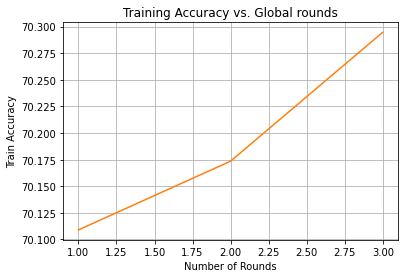

In [ ]:
# number of training rounds
rounds = 3
# client fraction
C = 0.5
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 3
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = iid_partition(training_set, 10)
d = {}
loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

bert_iid_trained,train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [ ]:
def calcuate_accuracy(big_idx, targets):
  n_correct = (big_idx==targets).sum().item()
  return n_correct

In [ ]:
#Testing the trained model

def valid(model, testing_loader, loss_function):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [ ]:
import pickle

print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(bert_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)

d['train_acc'] = train_acc
d['test_acc'] = acc


with open(f'/content/drive/My Drive/BERT/DPFLBERT_Dep_eps0_5.pkl', 'wb') as file:
  pickle.dump(d, file)

2it [00:00, 17.50it/s]

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 0.5948556661605835
Validation Accuracy per 100 steps: 100.0


310it [00:12, 24.83it/s]


Validation Loss Epoch: 0.6623207357621962
Validation Accuracy Epoch: 69.95153473344104
Accuracy on test data = 69.95%


In [ ]:
# number of training rounds
rounds = 3
# client fraction
C = 0.3
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 1
# batch size
batch_size = 5
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = non_iid_partition(training_set, 10, 240, 10, 10)
#iid_partition(training_set, 10)
d={}
loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

bert_non_iid_trained,train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [ ]:
import pickle
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(bert_non_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)


d['train_acc'] = train_acc
d['test_acc'] = acc


with open(f'/content/drive/My Drive/DPFLBERT_Dep_eps0_5_noniid.pkl', 'wb') as file:
  pickle.dump(d, file)